This notebook reads in a selected region of ALL SLCs, creates interferograms with them, and outputs the igram as an ISCE-readable file for using with SNAPHU. 


This notebook: <br>
(loops over all SLCs and does the following each time)
1. Reads in small window (defined in 'extract_ONE_igram...ipynb') of two SLCs 
2. Creates interferogram with them
3. Saves the full res igram as an ISCE-readable file.
4. Unwraps it???? WILL THIS WORK IN HERE???
5. (next time it will overwrite the igram file)

<br><br>
On command line: (don't have to do this in command line any more)
>start_isce <br>
>python testSnaphu.py infile outfile <br> <br>

To make an xml file that goes with the newly unwrapped igram: <br>
>cp igramTemp.r4.xml 20191021_20191027_unwr.r4.xml <br>
>fixImageXml.py -i 20191021_20191027_unwr.r4 -f <br> <br>

To open in mdx:
>mdx.py 20191021_20191027_unwr.r4 <br>
>mdx igramTemp.r4 3000 -cmap cmy -wrap 6.28 20191021_20191027_unwr.r4 3000 -cmap cmy -wrap 10 <br>


This notebook was written on 10-19-22

***

Import the things we need.

In [1]:
import os,sys
import glob
import pandas as pd
import math
from osgeo import gdal
import numpy as np
from array import array
from scipy  import signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

import isce
import isceobj
from contrib.Snaphu.Snaphu import Snaphu

import shutil
from imageMath import IML

# %matplotlib  widget

Using default ISCE Path: /home/rlohman/Software/isce-2.2.0/isce


like four lines from fixImageXml I would need  
from imageMath import IML
img, dataname, ...
img.filename...
img.setAccessMode('READ')
img.render

try it with the exclamation point 
could give it the absolute path like we did 
need to cpy a working xml file with correct width/length 

what's the simplest header file we can make for gdal? make that. 

First, on command line: 
>start_isce

Set the working directory and define dimensions of the SLC files we'll be loading in

In [2]:
workdir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
outputdir = str(workdir+'cropped_northern_shore_LS_for_unwrapping/')

# size of full res SLCs
dxIN=18000
dyIN=3600

If filtering first, use this window for filtering 

In [3]:
alooks=4
rlooks=20

Load in the dates of the SLCs for loading them.

In [4]:
# load in dates
dates = [os.path.basename(x) for x in glob.glob(workdir+"SLC_vv/2*")]
dates = sorted(dates)
nd = len(dates)

Read in 2 SLCs for full res unwrapping with SNAPHU.

In [5]:
# bounding box
x1 = 17000; x2 = 14000
y1 = 1750;  y2 = 1000
# output file size
dxOUT = int(np.abs(x1-x2))
dyOUT = int(np.abs(y1-y2))
print('range: '+str(dxOUT))
print('azimuth: '+str(dyOUT))
print('total number of pixels: '+str(dxOUT*dyOUT))
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')

# loop through the dates 
for i in range(1,nd-1): # range(nd-1) if doing all of them at once
    # define the 2 dates. 
    date1=dates[i]
    date2=dates[i+1]
    # Read in 2 full SLCs to make interferogram 
    ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
    slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
    #print('SLC 1 subsect loaded.')
    ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
    slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dxOUT,dyOUT)
    #print('SLC 2 subsect loaded.')
    intTemp = np.angle(slc1*np.conj(slc2))

    # This filtering is optional 
    s1=slc1*np.conj(slc1)
    s2=slc2*np.conj(slc2)
    a1r=gaussian_filter(np.real(s1), sigma=[alooks/4,rlooks/4])
    a1i=gaussian_filter(np.imag(s1), sigma=[alooks/4,rlooks/4])
    a2r=gaussian_filter(np.real(s2), sigma=[alooks/4,rlooks/4])
    a2i=gaussian_filter(np.imag(s2), sigma=[alooks/4,rlooks/4])
    a1 = a1r+1j*a1i
    a2 = a2r+1j*a2i
    filtimager=gaussian_filter(np.real(intTemp), sigma=[alooks/4,rlooks/4])
    filtimagei=gaussian_filter(np.imag(intTemp), sigma=[alooks/4,rlooks/4])
    intTemp = filtimager+1j*filtimagei
    #scaler    = np.sqrt(a1*a2)
    #intTemp = intTemp/scaler
    
    # save the file 
    igramFile = 'filtigramTemp1.r4'
    colds = driver.Create(outputdir+igramFile,dxOUT,dyOUT,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(intTemp)
    colds=None
    
    # output a string SNAPHU output (unwrapped) file to be named. 
    outfile = outputdir+date1+'_'+date2+'_filt_unwr.int'
    #print(outfile)
    inputFilename = outputdir+igramFile
    # try using SNAPHU in the loop
    #! start_isce
    #! python /data/ocp4/LagunaSalada/testSnaphu.py '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/igramTemp.r4' outfile
    #inputFilename = sys.argv[1]
    #outputFilename = sys.argv[2]
    snaphu = Snaphu()
    snaphu.setInput(inputFilename)
    snaphu.setOutput(outfile)
    snaphu.setWidth(3000) # this was 4800 for Rowena's test 
    snaphu.setCostMode('DEFO') # try SMOOTH, was DEFO to start
    snaphu.setEarthRadius(6356236.24233467)
    snaphu.setWavelength(0.0562356424)
    snaphu.setAltitude(788151.7928135)
    snaphu.setCorFileFormat('FLOAT_DATA')
    snaphu.setIntFileFormat('FLOAT_DATA')
    snaphu.setUnwFileFormat('FLOAT_DATA')

    print("Preparing")
    snaphu.prepare()
    snaphu.unwrap()

    copyThisFile = outputdir+'igramTemp.r4.xml'
    putItHere = outputdir+date1+'_'+date2+'_filt_unwr.int.xml'
    # copy the file
    shutil.copy(copyThisFile,putItHere)

    infile = outputdir+date1+'_'+date2+'_filt_unwr.int'
    #img, dataname, metaName = IML.loadImage(inps.infile) # original line
    img, dataname, metaName = IML.loadImage(infile)
    #img.filename = fname # original line of code 
    img.filename = putItHere
    img.setAccessMode('READ')
    img.renderHdr()
    # for some reason this makes an extra .xml.xml and .xml.vrt files that are unecessary, remove them 
    os.remove(putItHere+'.xml')
    os.remove(putItHere+'.vrt')


# call this from command line with this:
# python testSnaphu.py infile outfile



range: 3000
azimuth: 750
total number of pixels: 2250000
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Preparing
Pre

In [5]:
for i in range(nd-1): # do nd-1 for all igrams 
    date1=dates[i]
    date2=dates[i+1]
    copyThisFile = outputdir+'igramTemp.r4.xml'
    putItHere = outputdir+date1+'_'+date2+'_unwr.int.xml'
    # copy the file
    shutil.copy(copyThisFile,putItHere)

    infile = outputdir+date1+'_'+date2+'_unwr.int'
    #img, dataname, metaName = IML.loadImage(inps.infile) # original line
    img, dataname, metaName = IML.loadImage(infile)
    #img.filename = fname # original line of code 
    img.filename = putItHere
    img.setAccessMode('READ')
    img.renderHdr()
    # for some reason this makes an extra .xml.xml and .xml.vrt files that are unecessary, remove them 
    #os.remove(putItHere+'.xml')
    #os.remove(putItHere+'.vrt')

fixImageXml.py is found here: <br>
/home/rlohman/Software/isce-2.2.0/isce/applications/fixImageXml.py <br> <br>
This is how I use it in command line: <br>
fixImageXml.py -i 20170510_20170522_unwr.r4 -f

can look in documentation in IML packagePathMap
set width, some generic header? 

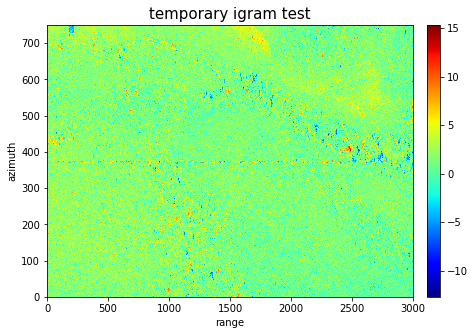

In [6]:
# test the one output I just did with fixImageXml code 

# load in unwrapped file and plot it to be sure SNAPHU worked. 
#f1 = gdal.Open((outputdir+'20191021_20191027_unwr.r4'), gdal.GA_ReadOnly)
file = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/20170510_20170522_unwr.int'
f1 = gdal.Open((file), gdal.GA_ReadOnly)
unwr_igram = f1.ReadAsArray()
f1 = None
# now plot it
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(unwr_igram)))
plt.colorbar(orientation='vertical',pad=0.03)
plt.set_cmap('jet')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('temporary igram test',fontsize=15)
plt.xlabel('range'); plt.ylabel('azimuth')
plt.show()